# Form factor to total density prediction model training
This notebook shows how a deep learning model can be trained to predict total density profiles from form factors. 
It contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html). 
2) Preprocess data for the machine learning pipeline.
3) Training and evaluating the performance of the neural network.

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "3"  # Set TensorFlow verbosity to lowest (only print errors)
)

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath = "./Databank/"  # this is the local path for the cloned Databank
sys.path.insert(1, databankPath + "/Scripts/BuildDatabank/")
from databankLibrary import *
from new_functions import *

systems = initialize_databank(databankPath)

Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


In [4]:
# Some systems have periodic boundary condition (PBC) warnings and should be excluded from the analysis
PBC_warning_count = 0
for system in systems:
    if "WARNINGS" in system.keys():
        if type(system["WARNINGS"]) == dict and "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            #print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
print("Number of systems with PBC warnings:", PBC_warning_count)

Number of systems with PBC warnings: 15


With the databank initiated, the form factor (ff) and total density (td) data of each simulation can be extracted from the "system" variables.  
Each form factor has a shape of (1000), but the total densities have dimensions that vary.  
The total densities are split into separate lists td_x and td_y.  

In [5]:
system_ids = []
all_ff = []
all_td_x = []
all_td_y = []
td_x_lengths = []
td_y_lengths = []

# Complete data should have form factors of length 1000
required_form_factor_dimension = 1000

# Load form factors and total densities
for system in systems:
    if "WARNINGS" in system.keys():  # Skip system with PBC warnings
        if type(system["WARNINGS"]) == dict and "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            continue
    FFsim, TDsim = getFormFactorAndTotalDensityPair(system, databankPath)
    if (
        isinstance(FFsim, list)
        and isinstance(TDsim, list)
        and len(FFsim) == required_form_factor_dimension
    ):
        system_ids.append(system["ID"]) # Add system ID to the list

        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff) # Add form factor to the list

        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x) # Add total density x values to the list
        all_td_y.append(td_y) # Add total density y values to the list
        td_x_lengths.append(len(td_x))
        td_y_lengths.append(len(td_y))

del systems
assert len(system_ids) == len(all_ff) == len(all_td_x) == len(all_td_y) # Be sure that there are as many form factors as total densitiess
assert td_x_lengths == td_y_lengths # Be sure that dimensions of x and y values match for every simulation
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 774


In [6]:
# Sort all lists by system id
system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths = [list(elem) for elem in zip(*sorted(zip(system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths)))]
print(system_ids)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,

### Take the time to get to know what the data looks like

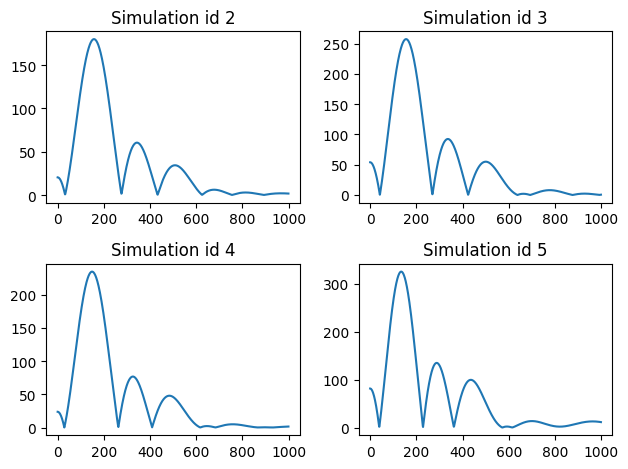

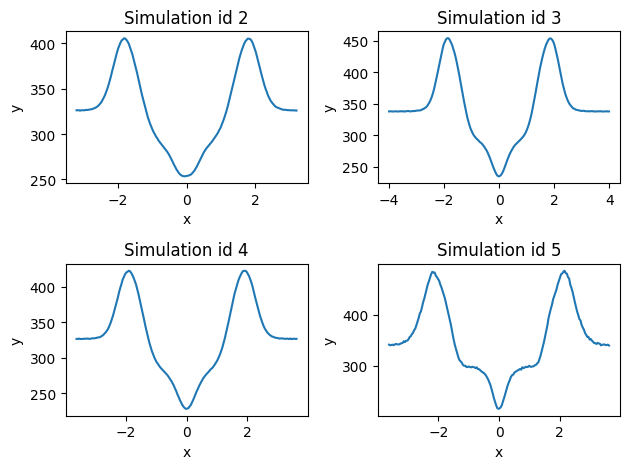

In [7]:
# Visualize form factors and total density profiles
# Rerun this block to cycle through different simulations
# start_of_plotting = 0  # Or use this line to reset the plot couinter

if 'start_of_plotting' not in globals():
    start_of_plotting = 0

# # Plot four density profiles
ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
#plt.suptitle("Form factors of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
#plt.suptitle("Density profiles of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
td_axs = td_axs.flatten()

plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(zip(system_ids, all_td_x, all_td_y, all_ff)):
    if plot_counter >= start_of_plotting:
        ff_axs[plot_index].plot(ff_vector)
        ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel("x")
        td_axs[plot_index].set_ylabel("y")
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting = plot_counter + 1
            break
ff_fig.tight_layout()
td_fig.tight_layout()

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range of the total densities varies between simulations.
- Most density profiles have flat "shoulders", but not all: Some seem to be truncated in the x direction.

In [8]:
# Find the systems with narrow x dimension
narrow_limit = 2.9 # Many systems whose total density profiles are narrower than [-2.9, 2.9] seem to have nonsmooth periodic conditions that are not marked by errors
narrow_td_systems = []
for system_id, x_vector, y_vector, ff_vector in zip(system_ids, all_td_x, all_td_y, all_ff):
    if max(x_vector) < narrow_limit:
        narrow_td_systems.append(system_id)
print("IDs of systems with narrow total densities:", narrow_td_systems)
print("Number of systems with narrow total densities:", len(narrow_td_systems))

IDs of systems with narrow total densities: [81, 94, 101, 124, 128, 277, 289, 344, 375, 378, 379, 477, 519, 582, 606, 614, 755, 756, 795, 796, 798, 799, 800, 802, 803, 804, 806, 807, 809, 810, 811, 812, 815, 816, 817, 818, 819]
Number of systems with narrow total densities: 37


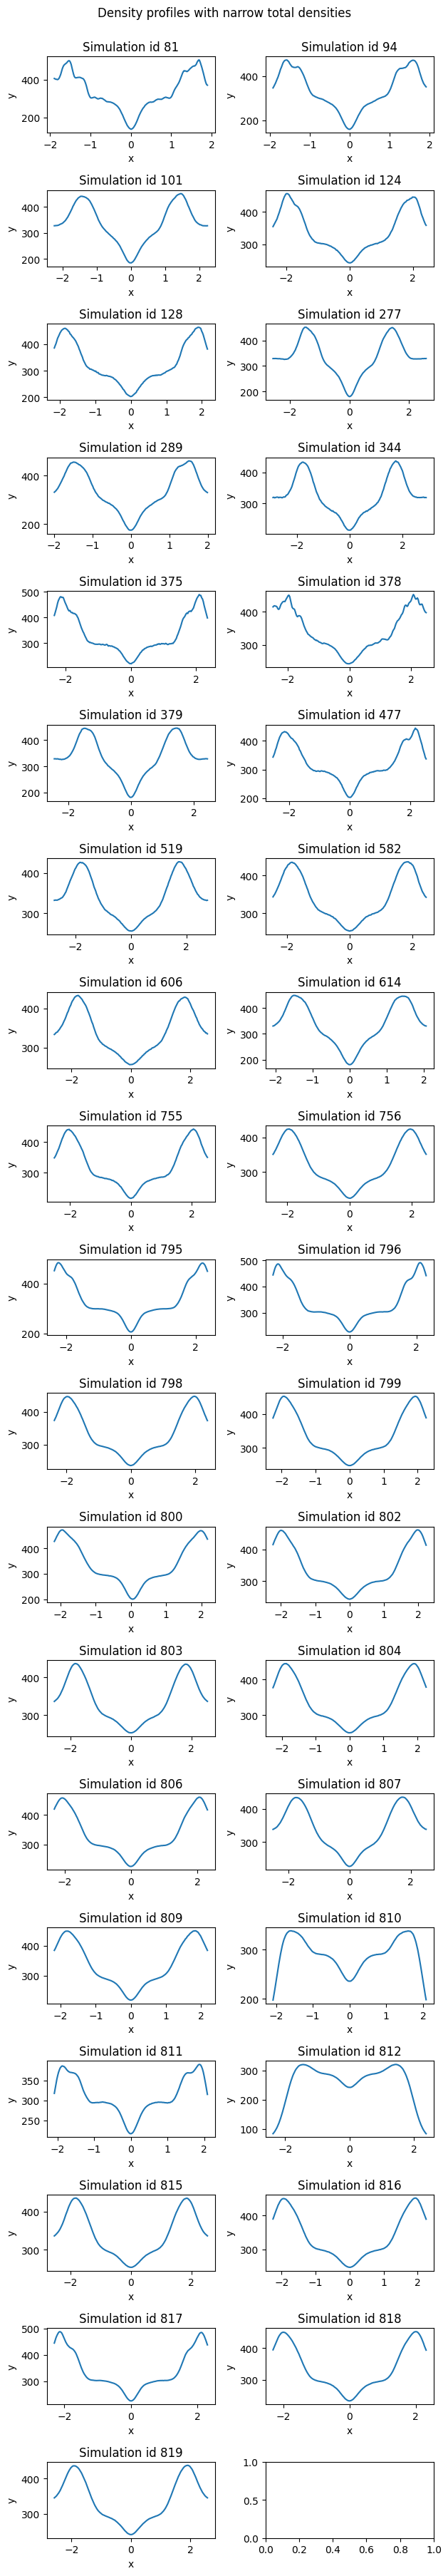

In [9]:
# Plot density profiles with nonsmooth boundaries
figrows = int(np.ceil(len(narrow_td_systems)/2))
pbc_fig, td_axs = plt.subplots(nrows=figrows, ncols=2)
plt.suptitle("Density profiles with narrow total densities")
td_axs = td_axs.flatten()

plot_index = 0
for system_id, x_vector, y_vector, ff_vector in zip(system_ids, all_td_x, all_td_y, all_ff):
    if system_id in narrow_td_systems:
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel("x")
        td_axs[plot_index].set_ylabel("y")
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
pbc_fig.set_figheight(2*figrows)
pbc_fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [10]:
# These are identified as fine after visual inspection: 
# narrow_but_fine_ids = [] #[39, 49, 86, 180, 275, 349, 493, 511, 691, 707, 811]
# Leaving these as problematic: 
# pbc_systems = [elem for elem in narrow_td_systems if elem not in narrow_but_fine_ids]
# print("IDs of systems with nonsmooth boundaries:", pbc_systems)

# # Narrow density profiles that have ok boundaries
# figrows = int(np.ceil(len(narrow_but_fine_ids)/2))
# pbc_fig, td_axs = plt.subplots(nrows=figrows, ncols=2)
# plt.suptitle("Narrow density profiles that have ok boundaries")
# td_axs = td_axs.flatten()

# plot_index = 0
# for simulation_counter, (x_vector, y_vector, ff_vector) in enumerate(zip(all_td_x, all_td_y, all_ff)):
#     if system_ids[simulation_counter] in narrow_but_fine_ids:
#         td_axs[plot_index].plot(x_vector, y_vector)
#         td_axs[plot_index].set_xlabel("x")
#         td_axs[plot_index].set_ylabel("y")
#         td_axs[plot_index].set_title("Simulation id " + str(system_ids[simulation_counter]))
#         plot_index += 1
# pbc_fig.set_figheight(2*figrows)
# pbc_fig.tight_layout(rect=[0, 0.03, 1, 0.98])

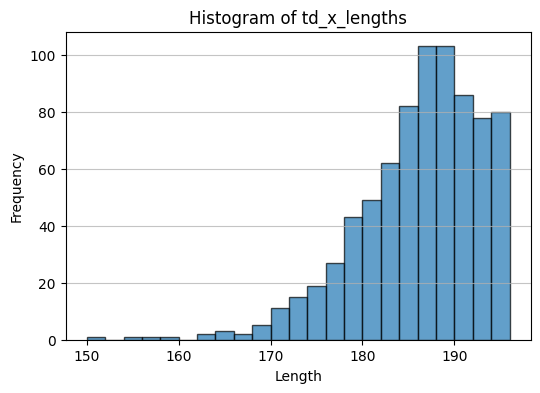

Every td_x length present in the dataset: {150, 154, 156, 158, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196}
(The lenght of td_y matches td_x for each simulation)


In [11]:
# Visualize that the length of the total density data varies between simulations
plt.figure(figsize=(6, 4))
plt.hist(td_x_lengths, bins=23, edgecolor='black', alpha=0.7)
plt.title("Histogram of td_x_lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()
print("Every td_x length present in the dataset:", set(td_x_lengths)) 
print("(The lenght of td_y matches td_x for each simulation)")

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range varies between simulations.
- Most density profiles have flat "shoulders", but not all. Some seem to be truncated in the x direction.

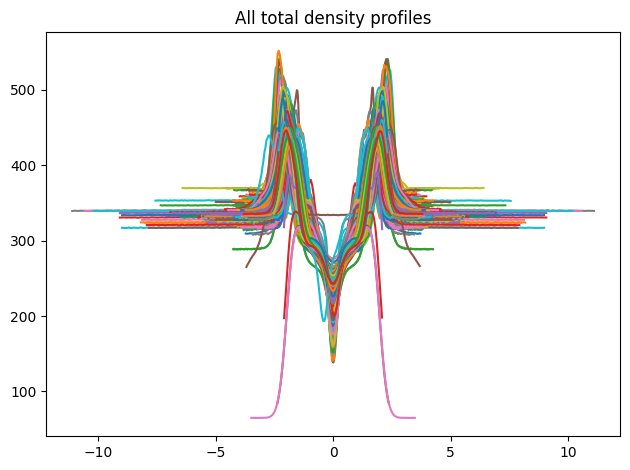

In [12]:
# Plot all total density profiles together
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, all_td_x, all_td_y)
plt.title("All total density profiles")
plt.tight_layout()
plt.show()

### Homogenize the data format of the total densities
The histogram of td_x_lengths shows that the different simulations have different numbers of observed values.
Furthermore, the plot of total densities shows that some total densities have long flat tails while others are seemingly truncated in the x direction. 
Since the model fitting requires data with a uniform format, a preprocessing process is needed to define a common x grid for the density profiles. 

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments.  
Aother option is to only include the widest experiments, but this also leads to a large loss of data.  
A compromise could be to trim the shoulders of the widest simulations, and extrapolate the narrowest simulations a bit. 

In the following code block, an x interval centered around zero is chosen. 
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window. 
This makes sure that all experiments have either actual measurements or extrapolated values across the entire x interval. 

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval.  
This brings all the data on the same format. 

In [13]:
# Define start and end of x interval
x_interval_start = -2.7
x_interval_end = 2.7
desired_length_of_padded_data = 400

padded_td_x = [
    extrapolate_X(td_x, desired_length_of_padded_data, x_interval_start, x_interval_end)
    for td_x in all_td_x
]
padded_td_y = [extrapolate_Y(td_y, desired_length_of_padded_data) for td_y in all_td_y]

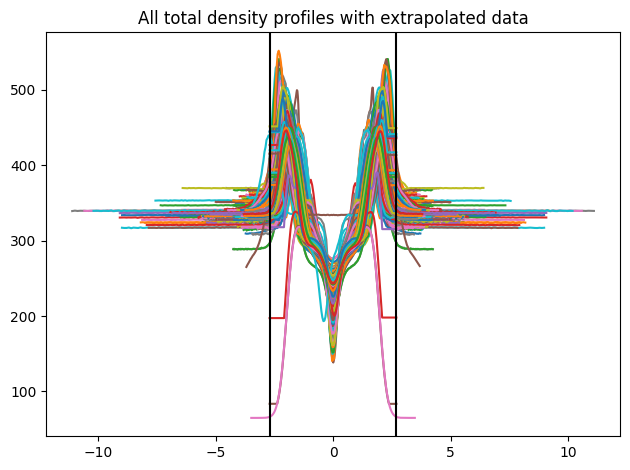

In [14]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, padded_td_x, padded_td_y, lines=[x_interval_start, x_interval_end]
)
plt.title("All total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

Rescale total densities to [0,1] range based on the max and min value among all densities.
This maintains internal differences in amplitude.

In [15]:
min_ff = min(min(sublist) for sublist in all_ff)
min_td_x = min(min(sublist) for sublist in padded_td_x)
min_td_y = min(min(sublist) for sublist in padded_td_y)

max_ff = max(max(sublist) for sublist in all_ff)
max_td_x = max(max(sublist) for sublist in padded_td_x)
max_td_y = max(max(sublist) for sublist in padded_td_y)


# Rescale by providing global min and max
def rescale(values, min_value, max_value):
    return (values - min_value) / (max_value - min_value) - 0.5


# Apply to each sublist in ff and td x and y
rescaled_all_ff = [rescale(ff, min_ff, max_ff) for ff in all_ff]
rescaled_all_td_x = [rescale(td_x, min_td_x, max_td_x) for td_x in padded_td_x]
rescaled_all_td_y = [rescale(td_y, min_td_y, max_td_y) for td_y in padded_td_y]

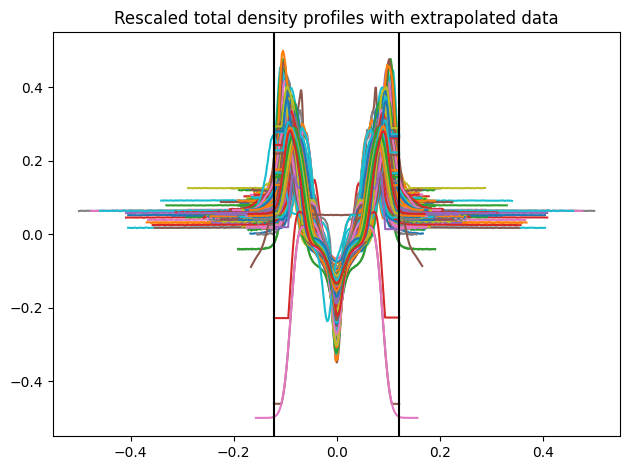

In [16]:
# Plot rescaled total density profiles

rescaled_start = rescale(x_interval_start, min_td_x, max_td_x)
rescaled_end = rescale(x_interval_end, min_td_x, max_td_x)

fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, rescaled_all_td_x, rescaled_all_td_y, lines=[rescaled_start, rescaled_end]
)
plt.title("Rescaled total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

In [17]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid

dimension_of_uniform_x_range = 200

# Define the points for prediction
uniform_x_range = np.linspace(rescaled_start, rescaled_end, dimension_of_uniform_x_range).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(
    rescaled_all_td_x, rescaled_all_td_y, uniform_x_range
)

Gather form factors and total densities in data frames.

In [18]:
# Convert the data to a pandas DataFrame
sim_FF_df = pd.DataFrame(rescaled_all_ff)
sim_TD_y_df = pd.DataFrame(standardized_y)

Get to know the data at a glance by calling the df name in a code block.

In [19]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.477839,-0.477861,-0.477927,-0.478036,-0.478189,-0.478386,-0.478626,-0.478910,-0.479237,-0.479608,...,-0.498015,-0.498029,-0.498042,-0.498056,-0.498071,-0.498086,-0.498101,-0.498116,-0.498132,-0.498148
1,-0.441322,-0.441357,-0.441462,-0.441638,-0.441884,-0.442199,-0.442585,-0.443040,-0.443565,-0.444159,...,-0.499898,-0.499886,-0.499847,-0.499796,-0.499740,-0.499681,-0.499622,-0.499561,-0.499500,-0.499439
2,-0.474253,-0.474284,-0.474379,-0.474536,-0.474757,-0.475040,-0.475386,-0.475794,-0.476265,-0.476798,...,-0.498507,-0.498490,-0.498474,-0.498459,-0.498443,-0.498429,-0.498414,-0.498401,-0.498387,-0.498374
3,-0.411471,-0.411532,-0.411715,-0.412020,-0.412446,-0.412994,-0.413663,-0.414453,-0.415362,-0.416392,...,-0.486858,-0.486925,-0.486995,-0.487067,-0.487141,-0.487217,-0.487296,-0.487376,-0.487459,-0.487544
4,-0.475552,-0.475576,-0.475646,-0.475762,-0.475926,-0.476136,-0.476392,-0.476695,-0.477043,-0.477438,...,-0.497871,-0.497882,-0.497893,-0.497905,-0.497918,-0.497932,-0.497947,-0.497963,-0.497979,-0.497996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,-0.102576,-0.102587,-0.102619,-0.102672,-0.102748,-0.102846,-0.102965,-0.103105,-0.103267,-0.103450,...,-0.488881,-0.488910,-0.488946,-0.488987,-0.489034,-0.489087,-0.489146,-0.489211,-0.489282,-0.489359
770,0.136641,0.136613,0.136530,0.136392,0.136198,0.135949,0.135645,0.135286,0.134871,0.134402,...,-0.488030,-0.487896,-0.487762,-0.487630,-0.487499,-0.487369,-0.487241,-0.487114,-0.486989,-0.486865
771,-0.052603,-0.052617,-0.052658,-0.052728,-0.052824,-0.052947,-0.053099,-0.053278,-0.053484,-0.053719,...,-0.493969,-0.494147,-0.494329,-0.494515,-0.494705,-0.494899,-0.495097,-0.495298,-0.495503,-0.495711
772,-0.390343,-0.390329,-0.390288,-0.390218,-0.390121,-0.389996,-0.389844,-0.389665,-0.389459,-0.389224,...,-0.495450,-0.495336,-0.495225,-0.495117,-0.495012,-0.494910,-0.494811,-0.494716,-0.494623,-0.494534


In [20]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.041327,0.042212,0.043302,0.044676,0.046350,0.048324,0.050619,0.053287,0.056387,0.059954,...,0.059139,0.055900,0.053113,0.050590,0.048251,0.046147,0.044407,0.043117,0.042202,0.041469
1,0.070989,0.072424,0.074388,0.077012,0.080254,0.083978,0.088097,0.092662,0.097817,0.103735,...,0.104140,0.098078,0.092817,0.088216,0.084133,0.080507,0.077353,0.074719,0.072568,0.070790
2,0.052186,0.054677,0.057532,0.060912,0.064892,0.069489,0.074707,0.080571,0.087102,0.094262,...,0.093427,0.086571,0.080294,0.074534,0.069310,0.064667,0.060648,0.057240,0.054357,0.051879
3,0.152637,0.163425,0.174412,0.185287,0.195995,0.206818,0.218048,0.229961,0.242527,0.255672,...,0.260792,0.246471,0.231850,0.217533,0.204163,0.192251,0.181873,0.172604,0.163893,0.155286
4,0.040000,0.040758,0.041874,0.043159,0.044403,0.045601,0.046976,0.048761,0.051205,0.054388,...,0.055214,0.051607,0.048188,0.045588,0.044250,0.043999,0.044085,0.043715,0.042469,0.040641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,0.167356,0.167724,0.167622,0.168018,0.167824,0.167492,0.167652,0.168037,0.168015,0.167576,...,0.166445,0.166840,0.166800,0.166443,0.166330,0.166670,0.166785,0.166377,0.166633,0.165392
770,0.280778,0.280292,0.280649,0.280182,0.280115,0.280630,0.280775,0.280178,0.279781,0.280300,...,0.266251,0.265907,0.266365,0.266830,0.266590,0.266140,0.266300,0.266693,0.266258,0.267197
771,0.176935,0.176601,0.176804,0.176485,0.176506,0.176830,0.176834,0.176460,0.176296,0.176674,...,0.174603,0.174219,0.174477,0.174877,0.174801,0.174440,0.174494,0.174829,0.174518,0.175390
772,0.076219,0.076236,0.076354,0.076236,0.076262,0.077773,0.081439,0.086775,0.092843,0.099111,...,0.097965,0.091917,0.086245,0.081334,0.077934,0.076506,0.076468,0.076600,0.076483,0.076465


### Plot form factors and total densities

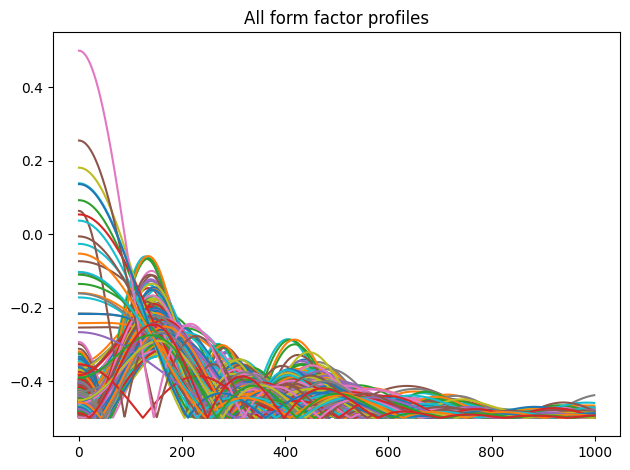

In [21]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df)
plt.title("All form factor profiles")
plt.tight_layout()
plt.show()

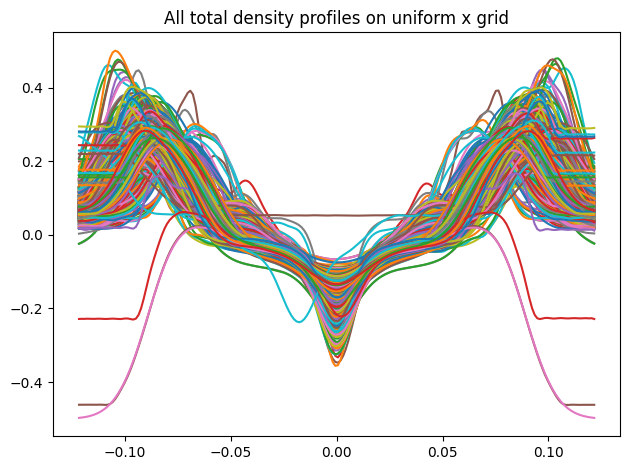

In [22]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, uniform_x_range, sim_TD_y_df)
plt.title("All total density profiles on uniform x grid")
plt.tight_layout()
plt.show()

Now the form factors and total densities are rescaled and on a uniform format. 

### Split data into train and test sets

In [23]:
train_input, train_output, test_input, test_output = split_train_and_test(
    sim_FF_df, sim_TD_y_df, rng
)
N_train = train_input.shape[0]
N_test = test_input.shape[0]
print("N_train:", N_train)
print("N_test:", N_test)

N_train: 619
N_test: 155


In [24]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
573,-0.455972,-0.456007,-0.456113,-0.456288,-0.456533,-0.456848,-0.457233,-0.457687,-0.458210,-0.458802,...,-0.498901,-0.498858,-0.498816,-0.498775,-0.498733,-0.498692,-0.498652,-0.498612,-0.498572,-0.498533
557,-0.473943,-0.473975,-0.474070,-0.474228,-0.474450,-0.474735,-0.475084,-0.475495,-0.475968,-0.476505,...,-0.499047,-0.499024,-0.499002,-0.498981,-0.498960,-0.498939,-0.498919,-0.498899,-0.498880,-0.498862
53,-0.483408,-0.483437,-0.483525,-0.483672,-0.483877,-0.484141,-0.484463,-0.484843,-0.485281,-0.485777,...,-0.499270,-0.499245,-0.499221,-0.499196,-0.499172,-0.499148,-0.499125,-0.499101,-0.499079,-0.499056
615,-0.475586,-0.475616,-0.475708,-0.475861,-0.476075,-0.476350,-0.476686,-0.477083,-0.477540,-0.478057,...,-0.497208,-0.497195,-0.497183,-0.497172,-0.497162,-0.497154,-0.497146,-0.497140,-0.497135,-0.497131
102,-0.421838,-0.421876,-0.421990,-0.422179,-0.422444,-0.422785,-0.423201,-0.423692,-0.424259,-0.424900,...,-0.498614,-0.498537,-0.498461,-0.498384,-0.498308,-0.498233,-0.498158,-0.498083,-0.498009,-0.497935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,-0.483441,-0.483485,-0.483616,-0.483835,-0.484141,-0.484534,-0.485014,-0.485581,-0.486234,-0.486973,...,-0.489042,-0.489021,-0.489004,-0.488989,-0.488978,-0.488970,-0.488965,-0.488964,-0.488966,-0.488971
228,-0.404672,-0.404724,-0.404878,-0.405135,-0.405495,-0.405958,-0.406522,-0.407188,-0.407956,-0.408824,...,-0.498427,-0.498413,-0.498398,-0.498383,-0.498368,-0.498352,-0.498336,-0.498320,-0.498304,-0.498288
436,-0.483045,-0.483073,-0.483159,-0.483301,-0.483500,-0.483756,-0.484069,-0.484439,-0.484864,-0.485346,...,-0.498892,-0.498812,-0.498732,-0.498653,-0.498574,-0.498495,-0.498417,-0.498338,-0.498261,-0.498184
526,-0.485460,-0.485485,-0.485562,-0.485691,-0.485870,-0.486101,-0.486383,-0.486715,-0.487099,-0.487533,...,-0.499073,-0.499038,-0.499003,-0.498968,-0.498933,-0.498897,-0.498862,-0.498827,-0.498792,-0.498758


In [25]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
573,0.035444,0.037183,0.039191,0.041587,0.044530,0.048146,0.052459,0.057394,0.062846,0.068774,...,0.067985,0.062004,0.056603,0.051878,0.047859,0.044427,0.041375,0.038566,0.036053,0.034049
557,0.072582,0.074711,0.077304,0.080235,0.083432,0.086948,0.090956,0.095644,0.101117,0.107337,...,0.108469,0.102454,0.097134,0.092464,0.088335,0.084623,0.081250,0.078229,0.075643,0.073579
53,0.072287,0.074687,0.077502,0.080660,0.084139,0.088010,0.092368,0.097302,0.102840,0.108981,...,0.109665,0.103184,0.097340,0.092197,0.087720,0.083786,0.080274,0.077130,0.074400,0.072169
615,0.053798,0.057478,0.062219,0.067786,0.073880,0.080374,0.087256,0.094620,0.102536,0.110970,...,0.110124,0.101642,0.093138,0.085292,0.078815,0.073861,0.069802,0.065753,0.061162,0.056268
102,0.072329,0.074237,0.076411,0.078939,0.082017,0.085904,0.090806,0.096746,0.103570,0.111066,...,0.110775,0.103534,0.097290,0.091908,0.087201,0.083014,0.079292,0.076089,0.073508,0.071618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.129199,0.138285,0.148535,0.159906,0.172269,0.185434,0.199210,0.213470,0.228163,0.243276,...,0.224753,0.205301,0.187863,0.172495,0.159023,0.147153,0.136631,0.127321,0.119187,0.112193
228,0.160803,0.166590,0.172149,0.177302,0.181946,0.186205,0.190431,0.195054,0.200371,0.206378,...,0.206684,0.201352,0.195169,0.188201,0.180811,0.173572,0.167037,0.161494,0.156827,0.152571
436,0.060762,0.062005,0.063427,0.065132,0.067257,0.069983,0.073509,0.077973,0.083369,0.089513,...,0.087990,0.082256,0.077318,0.073132,0.069624,0.066761,0.064466,0.062634,0.061161,0.059935
526,0.064558,0.066998,0.069475,0.071287,0.072206,0.072758,0.073792,0.076094,0.080053,0.085581,...,0.086359,0.083349,0.079967,0.076225,0.072744,0.070238,0.068867,0.068148,0.067379,0.066174


### Train a neural net

Minimal working solution:

In [26]:
# Adam = tf.keras.optimizers.Adam(amsgrad=True)
# inputs = keras.Input(shape=(required_form_factor_dimension,))
# x = layers.Dense(required_form_factor_dimension, activation="relu")(inputs)
# outputs = layers.Dense(dimension_of_uniform_x_range, activation="linear")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=Adam, loss="mean_absolute_error")
# history = model.fit(
#     train_input,
#     train_output,
#     batch_size=128,
#     epochs=1500,
#     validation_split=0.2,
#     callbacks=[
#         EarlyStopping(
#             monitor="val_loss", mode="min", patience=100, restore_best_weights=True
#         )
#     ],
#     verbose=0,
# )

In [27]:
general_start_time = time.time()

# This defines an Amsgrad variant of the Adam optimizer. Usually some variant
# of Adam is first used to give an idea for performance, before other optimizers are used
Adam = tf.keras.optimizers.Adam(amsgrad=True)

# This defines the given input to be a required_form_factor_dimension long vector
inputs = keras.Input(shape=(required_form_factor_dimension,))

# This defines a regular neural network layer of required_form_factor_dimension neurons using the activation function called reLu.
# ReLu is also usually used to give an idea for perfomrance, before other activation functions are used
x = layers.Dense(required_form_factor_dimension, activation="relu")(inputs)

# This defines an output layer, which is a regular neural network layer of 200 neurons using the
# linear activation function, which means all neurons are activated with their weighted outputs.
outputs = layers.Dense(200, activation="linear")(x)

# This defines a model architecture
model = keras.Model(inputs=inputs, outputs=outputs)

# This compiles a model using a Adam optimizer and the intended training loss, which is mean absolute error
# Usually mean squared error is used for regression predictions, but since the output isn't suitable for it
# due to keras loss functions not knowing the division of x-axis and y-axis values, mean absolute error is used
model.compile(optimizer=Adam, loss="mean_absolute_error")

# This used the given training data to traing the model with
# max 1500 epochs, validation split of 20 % and a training batch size of 128.
# Usually epoch amounts are around 20 to 100, which is why we are giving the model a lot of tries to adjust
# The given batch size divides the available training data of 490 into 128,128,128 and 106 separate batches
# that are used to train the network. Larger batch sizes make the network converge faster, while smaller batch sizes
# make the network updates more granural, increasing the used time
history = model.fit(
    train_input,
    train_output,
    batch_size=128,
    epochs=1500,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", patience=100, restore_best_weights=True
        )
    ],
    verbose=0,
)

# Time use
general_end_time = time.time()
print("Used time: " + str(general_end_time - general_start_time) + " seconds")

Used time: 41.56927013397217 seconds


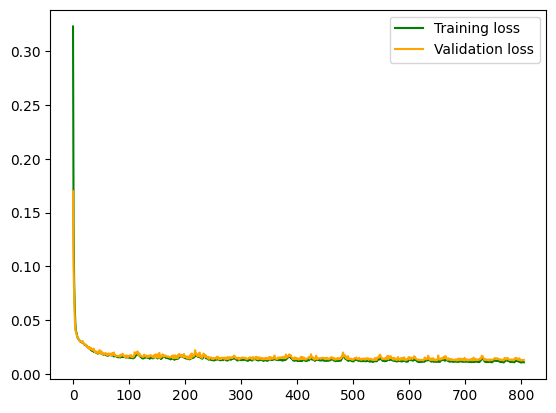

In [28]:
# Plot the training history of the model
fig, ax = plt.subplots()
ax = plot_training_trajectory(ax, history)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


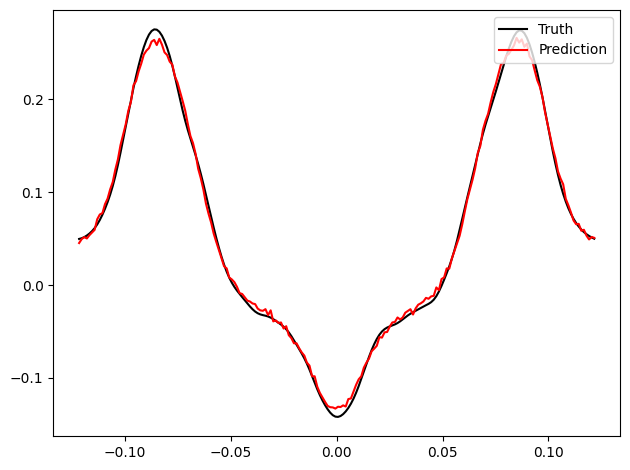

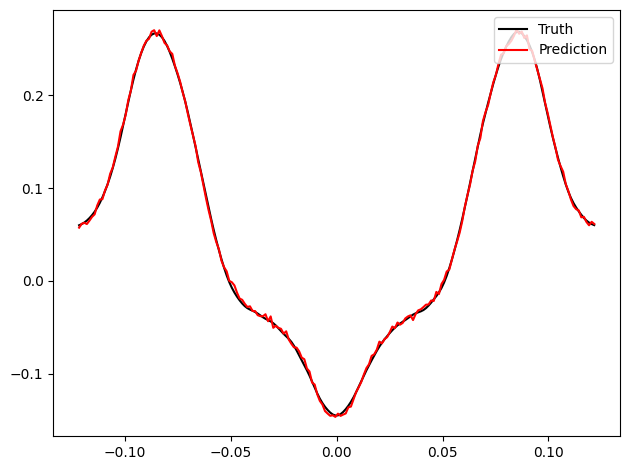

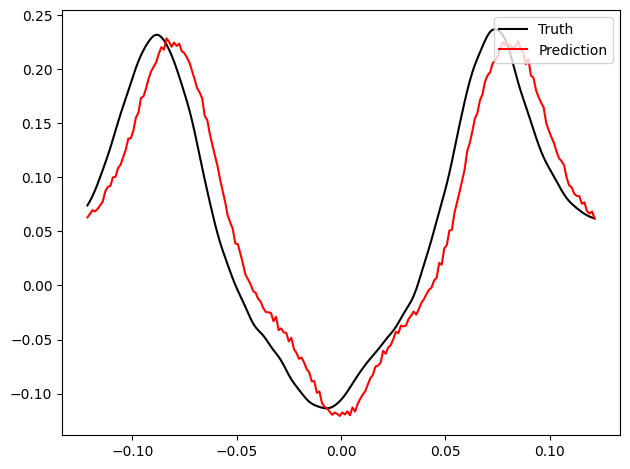

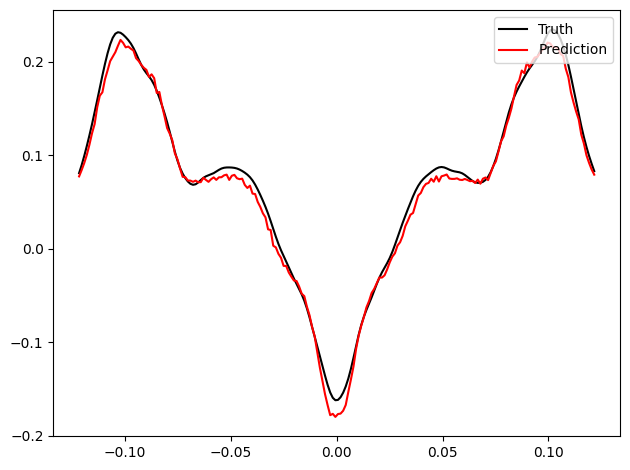

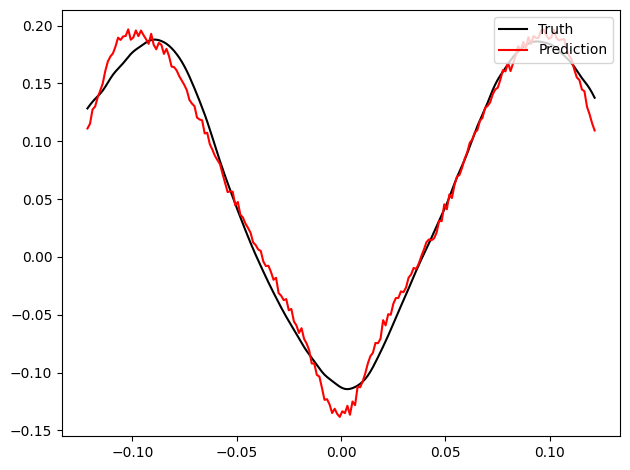

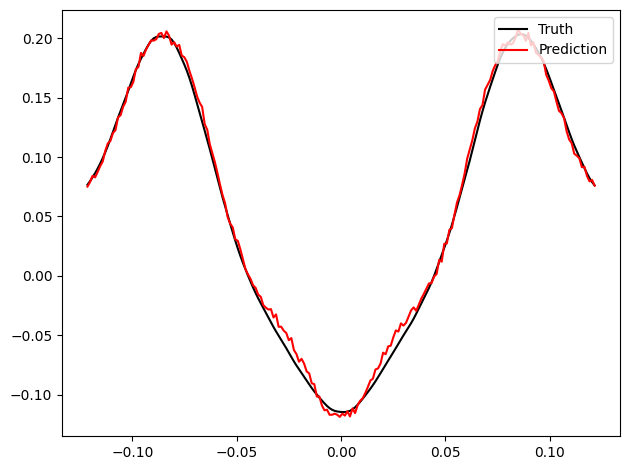

In [29]:
# Compare predictions to truth for five randomly chosen test cases
predictions = model.predict(test_input)
random_test_indices = rng.integers(low=0, high=N_test, size=6)
for idx in random_test_indices:
    fig, ax = plt.subplots()
    ax.plot(
        uniform_x_range,
        test_output.values[idx],
        color="k",
        linestyle="-",
        label="Truth",
    )
    ax.plot(
        uniform_x_range, predictions[idx], color="r", linestyle="-", label="Prediction"
    )
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

To improve the performance of the neural network, we optimize the hyperparameters using a grid search over feasible hyperparameters:  
The number of layers, neurons in each layer, activation function, optimizer, learning rate, batch size, and epochs. 

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X, y = make_moons()
calibrated_forest = CalibratedClassifierCV(
   estimator=RandomForestClassifier(n_estimators=10))
param_grid = {
   'estimator__max_depth': [2, 4, 6, 8]}
search = RandomizedSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(X, y)

# Dropout

/Users/even/Library/Caches/pypoetry/virtualenvs/nmrlipids-emHCjlKO-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=10)),
                   param_distributions={'estimator__max_depth': [2, 4, 6, 8]})